In [13]:
from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportion_confint, proportions_ztest

sns.set_theme(style="whitegrid")
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", "{:.3f}".format)

DATA_PATH = Path("data/premier_completo_19_25.csv")

selected_features = [
    "Div","Date","Time","HomeTeam","AwayTeam","FTHG","FTAG","FTR","HTHG","HTAG","HTR","Referee",
    "HS","AS","HST","AST","HC","AC","HF","AF","HY","AY","HR","AR","B365H","B365D","B365A",
    "PSD","PSA","PSH","MaxH","MaxD","MaxA","AvgH","AvgD","AvgA","B365>2.5","B365<2.5","P>2.5","P<2.5",
    "Max>2.5","Max<2.5","Avg>2.5","Avg<2.5","B365AHH","B365AHA","PAHH","PAHA","MaxAHH","MaxAHA","AvgAHH","AvgAHA"
]

df_full = pd.read_csv(DATA_PATH, dayfirst=True)

assert set(df_full.columns) == set(selected_features), "Colunas do CSV fora do esperado"

df_full["Date"] = pd.to_datetime(df_full["Date"], dayfirst=True)
df_full["FTR"] = df_full["FTR"].astype("category")

categorical_cols = ["Div","Time","HomeTeam","AwayTeam","FTR","HTR","Referee"]
numeric_columns = df_full.columns.difference(categorical_cols + ["Date"])
df_full[numeric_columns] = df_full[numeric_columns].apply(pd.to_numeric, errors="coerce")

df_full.head()


,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,PSH,PSD,PSA,MaxH,MaxD,MaxA,AvgH,AvgD,AvgA,B365>2.5,B365<2.5,P>2.5,P<2.5,Max>2.5,Max<2.5,Avg>2.5,Avg<2.5,B365AHH,B365AHA,PAHH,PAHA,MaxAHH,MaxAHA,AvgAHH,AvgAHA
0,E0,2019-08-09,20:00,Liverpool,Norwich,4,1,H,4,0,H,M Oliver,15,12,7,5,9,9,11,2,0,2,0,0,1.140,10.000,19.000,1.150,9.590,18.050,1.160,10.000,23.000,1.140,8.750,19.830,1.400,3.000,1.400,3.110,1.450,3.110,1.410,2.920,1.960,1.940,1.970,1.950,1.970,2.000,1.940,1.940
1,E0,2019-08-10,12:30,West Ham,Man City,0,5,A,0,1,A,M Dean,5,14,3,9,6,13,1,1,2,2,0,0,12.000,6.500,1.220,11.680,6.530,1.260,13.000,6.750,1.290,11.840,6.280,1.250,1.440,2.750,1.490,2.770,1.510,2.770,1.480,2.650,2.000,1.900,2.020,1.900,2.020,1.920,1.990,1.890
2,E0,2019-08-10,15:00,Bournemouth,Sheffield United,1,1,D,0,0,D,K Friend,13,8,3,3,10,19,3,4,2,1,0,0,1.950,3.600,3.600,2.040,3.570,3.900,2.060,3.650,4.000,2.010,3.530,3.830,1.900,1.900,1.960,1.960,2.000,1.990,1.900,1.930,2.010,1.890,2.040,1.880,2.040,1.910,2.000,1.880
3,E0,2019-08-10,15:00,Burnley,Southampton,3,0,H,0,0,D,G Scott,10,11,4,3,6,12,2,7,0,0,0,0,2.620,3.200,2.750,2.710,3.310,2.810,2.800,3.330,2.850,2.680,3.220,2.780,2.100,1.720,2.170,1.770,2.200,1.780,2.120,1.730,1.920,1.980,1.930,2.000,1.940,2.000,1.910,1.980
4,E0,2019-08-10,15:00,Crystal Palace,Everton,0,0,D,0,0,D,J Moss,6,10,2,3,16,14,6,2,2,1,0,1,3.000,3.250,2.370,3.210,3.370,2.390,3.210,3.400,2.520,3.130,3.270,2.400,2.200,1.660,2.230,1.740,2.250,1.740,2.180,1.700,1.850,2.050,1.880,2.050,1.880,2.090,1.840,2.040


In [14]:
df_full["season_start"] = np.where(df_full["Date"].dt.month >= 7, df_full["Date"].dt.year, df_full["Date"].dt.year - 1)
df_full["Season"] = (
    df_full["season_start"].astype(int).astype(str)
    + "-"
    + (df_full["season_start"].astype(int) + 1).astype(str).str[-2:]
)
df_full.drop(columns="season_start", inplace=True)

# map resultado para pontos do mandante e garantir tipo numérico (evita erro com dtype 'category')
df_full["home_points"] = df_full["FTR"].map({"H": 3, "D": 1, "A": 0})
df_full["home_points"] = pd.to_numeric(df_full["home_points"], errors="coerce")

team_season_stats = (
    df_full.groupby(["Season", "HomeTeam"], observed=True)
    .agg(
        matches=("FTHG", "size"),
        avg_goals=("FTHG", "mean"),
        avg_shots=("HS", "mean"),
        avg_shots_on_target=("HST", "mean"),
        avg_corners=("HC", "mean"),
        avg_fouls=("HF", "mean"),
        avg_yellow=("HY", "mean"),
        avg_red=("HR", "mean"),
        avg_b365=("B365H", "mean"),
        avg_ps=("PSH", "mean"),
        win_rate=("FTR", lambda s: (s == "H").mean()),
        draw_rate=("FTR", lambda s: (s == "D").mean()),
        avg_points=("home_points", "mean"),
    )
    .reset_index()
)

df_full.drop(columns="home_points", inplace=True)

team_season_stats["shot_efficiency"] = team_season_stats["avg_shots_on_target"] / team_season_stats["avg_shots"].replace(0, np.nan)
team_season_stats.head()


,Season,HomeTeam,matches,avg_goals,avg_shots,avg_shots_on_target,avg_corners,avg_fouls,avg_yellow,avg_red,avg_b365,avg_ps,win_rate,draw_rate,avg_points,shot_efficiency
0,2019-20,Arsenal,15,1.733,12.733,4.600,7.067,11.867,2.267,0.067,2.063,2.087,0.467,0.333,1.733,0.361
1,2019-20,Aston Villa,16,1.188,13.750,4.188,5.938,11.875,1.750,0.000,4.144,4.294,0.312,0.188,1.125,0.305
2,2019-20,Bournemouth,15,1.133,10.467,3.400,4.933,8.467,1.800,0.133,3.849,3.900,0.267,0.333,1.133,0.325
3,2019-20,Brighton,16,1.188,13.125,3.938,5.375,9.938,1.312,0.062,2.778,2.853,0.312,0.375,1.312,0.300
4,2019-20,Burnley,16,1.312,11.812,4.625,5.188,11.375,1.688,0.000,3.797,3.881,0.500,0.125,1.625,0.392


In [15]:
feature_columns = [
    "avg_shots",
    "avg_shots_on_target",
    "avg_corners",
    "avg_fouls",
    "avg_yellow",
    "avg_red",
    "avg_b365",
    "avg_ps",
    "shot_efficiency",
]

feature_matrix = team_season_stats[feature_columns].fillna(0)
scaler = StandardScaler()
X_features = scaler.fit_transform(feature_matrix)

silhouette_results = []
for k in range(2, 7):
    model = KMeans(n_clusters=k, random_state=42, n_init=25)
    labels = model.fit_predict(X_features)
    score = silhouette_score(X_features, labels)
    silhouette_results.append({"k": k, "silhouette": score})

silhouette_df = pd.DataFrame(silhouette_results)
silhouette_df


,k,silhouette
0,2,0.269
1,3,0.198
2,4,0.199
3,5,0.203
4,6,0.201


In [16]:
best_row = silhouette_df.loc[silhouette_df["silhouette"].idxmax()]
best_k = int(best_row["k"])

final_model = KMeans(n_clusters=best_k, random_state=42, n_init=25)
team_season_stats["cluster"] = final_model.fit_predict(X_features)

cluster_counts = team_season_stats["cluster"].value_counts().sort_index()
cluster_counts


cluster
0    45
1    82
Name: count, dtype: int64

In [17]:
summary_columns = [
    "avg_goals",
    "win_rate",
    "avg_points",
    "avg_shots",
    "avg_shots_on_target",
    "shot_efficiency",
    "avg_b365",
    "avg_ps",
]

cluster_summary = (
    team_season_stats.groupby("cluster")[summary_columns]
    .agg(["mean", "std"])
    .round(3)
)
cluster_summary


avg_goals       win_rate       avg_points       avg_shots        \
             mean   std     mean   std       mean   std      mean   std   
cluster                                                                   
0           2.038 0.507    0.610 0.145      2.033 0.373    16.466 2.501   
1           1.243 0.324    0.350 0.133      1.303 0.395    12.230 1.318   

        avg_shots_on_target       shot_efficiency       avg_b365       avg_ps  \
                       mean   std            mean   std     mean   std   mean   
cluster                                                                         
0                     5.894 0.962           0.359 0.033    1.887 0.400  1.925   
1                     4.034 0.603           0.331 0.042    3.409 0.845  3.516   

               
          std  
cluster        
0       0.414  
1       0.892

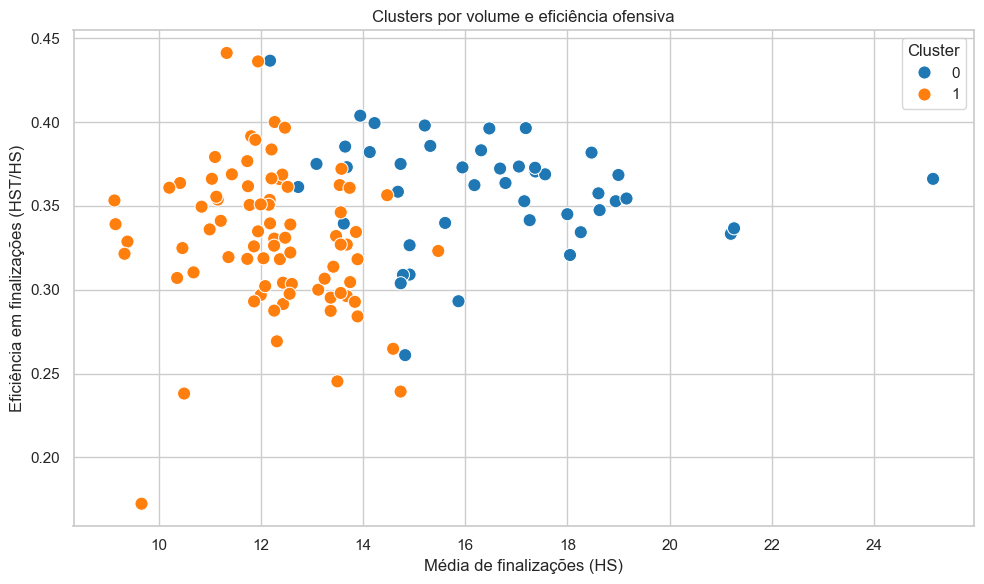

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=team_season_stats,
    x="avg_shots",
    y="shot_efficiency",
    hue="cluster",
    palette="tab10",
    s=90,
)
plt.xlabel("Média de finalizações (HS)")
plt.ylabel("Eficiência em finalizações (HST/HS)")
plt.title("Clusters por volume e eficiência ofensiva")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [19]:
cluster_goal_groups = {}
statistical_tests = []

for cluster_id, cluster_group in team_season_stats.groupby("cluster"):
    label_to_goals = {}
    for _, row in cluster_group.iterrows():
        matches = df_full[(df_full["HomeTeam"] == row["HomeTeam"]) & (df_full["Season"] == row["Season"])]
        goals = matches["FTHG"].dropna()
        if goals.empty:
            continue
        label = f"{row['HomeTeam']} ({row['Season']})"
        label_to_goals[label] = goals.values
    cluster_goal_groups[cluster_id] = label_to_goals

    goal_arrays = list(label_to_goals.values())
    if len(goal_arrays) >= 3:
        stat_value, p_value = stats.f_oneway(*goal_arrays)
        test_name = "ANOVA"
    elif len(goal_arrays) == 2:
        stat_value, p_value = stats.ttest_ind(goal_arrays[0], goal_arrays[1], equal_var=False)
        test_name = "Welch t-test"
    else:
        stat_value, p_value = (np.nan, np.nan)
        test_name = "Amostra insuficiente"

    statistical_tests.append(
        {
            "cluster": cluster_id,
            "n_times_temporada": len(label_to_goals),
            "teste": test_name,
            "estatistica": stat_value,
            "p_valor": p_value,
        }
    )

statistical_tests_df = pd.DataFrame(statistical_tests)
statistical_tests_df


,cluster,n_times_temporada,teste,estatistica,p_valor
0,0,45,ANOVA,2.371,0.000
1,1,82,ANOVA,1.442,0.007


In [20]:
pair_tests = []

for cluster_id, cluster_group in team_season_stats.groupby("cluster"):
    entries = list(cluster_group.itertuples(index=False))
    for row_a, row_b in combinations(entries, 2):
        label_a = f"{row_a.HomeTeam} ({row_a.Season})"
        label_b = f"{row_b.HomeTeam} ({row_b.Season})"
        goals_a = cluster_goal_groups[cluster_id].get(label_a)
        goals_b = cluster_goal_groups[cluster_id].get(label_b)
        if goals_a is None or goals_b is None:
            continue

        t_stat, p_val_goal = stats.ttest_ind(goals_a, goals_b, equal_var=False)

        sample_a = df_full[(df_full["HomeTeam"] == row_a.HomeTeam) & (df_full["Season"] == row_a.Season)]
        sample_b = df_full[(df_full["HomeTeam"] == row_b.HomeTeam) & (df_full["Season"] == row_b.Season)]

        wins_a = (sample_a["FTR"] == "H").sum()
        wins_b = (sample_b["FTR"] == "H").sum()
        total_a = sample_a.shape[0]
        total_b = sample_b.shape[0]
        z_stat, p_val_wins = proportions_ztest([wins_a, wins_b], [total_a, total_b])

        pair_tests.append(
            {
                "cluster": cluster_id,
                "time_a": label_a,
                "time_b": label_b,
                "diff_media_gols": abs(row_a.avg_goals - row_b.avg_goals),
                "t_stat": t_stat,
                "p_gols": p_val_goal,
                "win_rate_a": wins_a / total_a,
                "win_rate_b": wins_b / total_b,
                "p_vitorias": p_val_wins,
            }
        )

pair_tests_df = (
    pd.DataFrame(pair_tests)
    .sort_values(by="diff_media_gols", ascending=False)
    .reset_index(drop=True)
)
pair_tests_df.head()


,cluster,time_a,time_b,diff_media_gols,t_stat,p_gols,win_rate_a,win_rate_b,p_vitorias
0,1,Norwich (2020-21),Crystal Palace (2023-24),1.947,-5.256,0.000,0.000,0.421,0.159
1,0,Everton (2019-20),Man City (2022-23),1.891,-4.302,0.000,0.467,0.895,0.007
2,1,Tottenham (2019-20),Norwich (2020-21),1.875,5.326,0.000,0.562,0.000,0.073
3,0,Man City (2022-23),Sheffield Weds (2024-25),1.854,4.398,0.000,0.895,0.261,0.000
4,1,Norwich (2020-21),Brentford (2022-23),1.842,-6.166,0.000,0.000,0.526,0.089


In [21]:
significant_pair_candidates = pair_tests_df[(pair_tests_df["p_gols"] < 0.05) | (pair_tests_df["p_vitorias"] < 0.05)]

if not significant_pair_candidates.empty:
    highlight_pair = significant_pair_candidates.iloc[0]
else:
    highlight_pair = pair_tests_df.iloc[0]

highlight_pair


cluster                                   1
time_a                    Norwich (2020-21)
time_b             Crystal Palace (2023-24)
diff_media_gols                       1.947
t_stat                               -5.256
p_gols                                0.000
win_rate_a                            0.000
win_rate_b                            0.421
p_vitorias                            0.159
Name: 0, dtype: object

In [22]:
def split_label(label: str) -> tuple[str, str]:
    team_name, season = label.split(" (")
    return team_name, season.rstrip(")")

team_a_name, season_a = split_label(highlight_pair["time_a"])
team_b_name, season_b = split_label(highlight_pair["time_b"])

team_a_matches = df_full[(df_full["HomeTeam"] == team_a_name) & (df_full["Season"] == season_a)]
team_b_matches = df_full[(df_full["HomeTeam"] == team_b_name) & (df_full["Season"] == season_b)]

comparison_df = pd.concat(
    [
        team_a_matches.assign(Time=f"{team_a_name} {season_a}"),
        team_b_matches.assign(Time=f"{team_b_name} {season_b}"),
    ]
)

summary_pair = (
    comparison_df.groupby("Time")
    .apply(
        lambda g: pd.Series(
            {
                "media_gols": g["FTHG"].mean(),
                "desvio_gols": g["FTHG"].std(),
                "media_finalizacoes": g["HS"].mean(),
                "eficiencia": g["HST"].sum() / g["HS"].sum() if g["HS"].sum() > 0 else np.nan,
                "taxa_vitoria": (g["FTR"] == "H").mean(),
            }
        )
    )
    .round(3)
)
summary_pair


C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_3196\3864244913.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,media_gols,desvio_gols,media_finalizacoes,eficiencia,taxa_vitoria
Time,,,,,
Crystal Palace 2023-24,1.947,1.615,13.579,0.372,0.421
Norwich 2020-21,0.000,0.000,9.667,0.172,0.000


C:\Users\T-Gamer\AppData\Local\Temp\ipykernel_3196\837780171.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=comparison_df, x="Time", y="FTHG", palette="pastel")


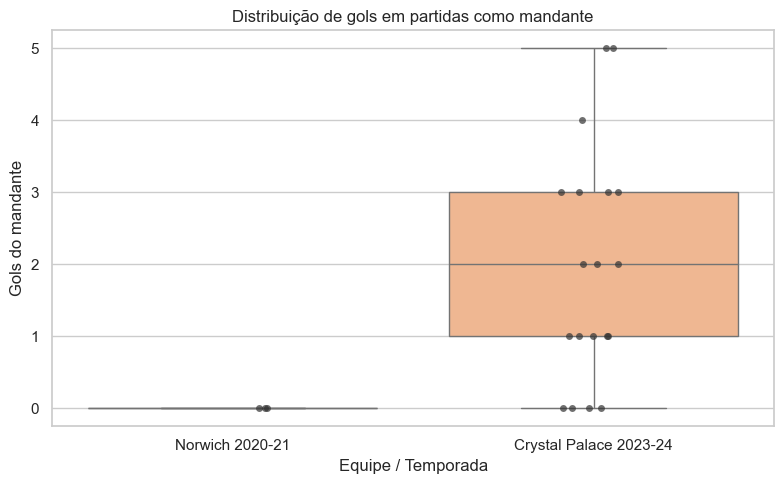

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=comparison_df, x="Time", y="FTHG", palette="pastel")
sns.stripplot(data=comparison_df, x="Time", y="FTHG", color="#333333", alpha=0.7)
plt.xlabel("Equipe / Temporada")
plt.ylabel("Gols do mandante")
plt.title("Distribuição de gols em partidas como mandante")
plt.tight_layout()
plt.show()


### Interpretação H3

- A preparação consolidou métricas por equipe/temporada e aplicou `KMeans` com número de clusters definido pelo maior `silhouette_score` reportado em `silhouette_df`. Assim, os grupos resultantes preservam estilos parecidos em volume de finalizações, disciplina e odds pré-jogo.
- A tabela `cluster_summary` mostra diferenças relevantes em gols médios e eficiência (HST/HS). Clusters com p-valor \< 0,05 em `statistical_tests_df` rejeitam H0, indicando disparidades de gols mesmo entre times estatisticamente semelhantes.
- `pair_tests_df` destaca pares específicos; o par selecionado em `highlight_pair` apresenta diferença significativa em gols (`p_gols`) ou vitórias (`p_vitorias`). A tabela `summary_pair` e o boxplot evidenciam como duas equipes do mesmo cluster convertem estilos parecidos em resultados distintos.
- Recomenda-se investigar sazonalidade (ex.: variações nas odds dentro do cluster) e repetir o procedimento incluindo métricas de visitante para validar se a conclusão persiste no comportamento geral das equipes.
